<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/iALIGNN_FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%time
!pip install  -q dgl -f https://data.dgl.ai/wheels/torch-2.1/repo.html # for cpu only
!pip install -q git+https://github.com/usnistgov/alignn.git@develop
# !pip install  -q dgl -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
# Alternate
# !conda install alignn dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
CPU times: user 140 ms, sys: 31.5 ms, total: 172 ms
Wall time: 20.7 s


In [29]:
from jarvis.db.figshare import data
from jarvis.db.jsonutils import loadjson,dumpjson
import torch
from alignn.ff.calculators import iAlignnAtomwiseCalculator,AlignnAtomwiseCalculator  # Import from new locationx`
from jarvis.core.atoms import Atoms
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import numpy as np
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from jarvis.io.vasp.inputs import Poscar
from tqdm import tqdm
interface_db = data("interfacedb")
atoms = Atoms.from_dict(interface_db[0]["atoms"])
calc = iAlignnAtomwiseCalculator()
ase_atoms = atoms.ase_converter()

ase_atoms.calc=calc
en = ase_atoms.get_potential_energy()

Obtaining vacancy dataset 607...
Reference:https://doi.org/10.1039/D4DD00031E
Loading the zipfile...
Loading completed.
dir_path /usr/local/lib/python3.11/dist-packages/alignn/ff/v12.2.2024_dft_3d_307k
dir_path /usr/local/lib/python3.11/dist-packages/alignn/ff/v2024.12.12_dft_3d_multi_prop


/usr/local/lib/python3.11/dist-packages/alignn/ff/calculators.py:405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(
/usr/local/lib/python3.11/dist-packages/align

(0.0, 8.330258930080904, 0.0, 37.075442103)

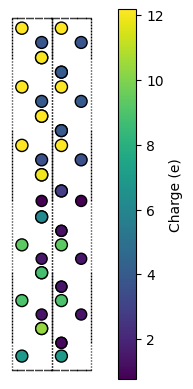

In [30]:
charges=ase_atoms.get_charges()
norm = plt.Normalize(min(charges), max(charges))
cmap = cm.viridis
colors = cmap(norm(charges))
fig, ax = plt.subplots()
plot_atoms(
    atoms.ase_converter(),
    ax,
    radii=0.5,
    rotation=("90x,45y,0z"),
    colors=colors,
)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap), label="Charge (e)", ax=ax
)  # Colorbar

plt.axis("off")


(0.0, 8.330258930080904, 0.0, 37.075442103)

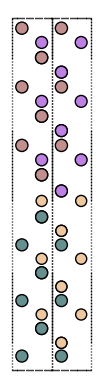

In [31]:
fig, ax = plt.subplots()
plot_atoms(
    atoms.ase_converter(),
    ax,
    radii=0.5,
    rotation=("90x,45y,0z"),
)
plt.axis("off")


In [32]:
#prop_names = ase_atoms.calc.implemented_properties
prop_vals = ase_atoms.calc.results

In [33]:
for i in ase_atoms.calc.props:
  print(i,prop_vals[i])

cbm 3.738536834716797
vbm 3.343587636947632
gap 0.5751546621322632
efermi 3.486661911010742
optb88vdw_bandgap 0.528291642665863
mbj_bandgap 1.2063931226730347
spillage 0.1900632381439209
slme 16.0008602142334
bulk_modulus_kv 46.99241638183594
shear_modulus_gv 24.733217239379883
n-Seebeck -75.73609161376953
n-powerfact 1155.1607666015625
avg_elec_mass 0.2749825119972229
avg_hole_mass 0.522271990776062
epsx 7.125207424163818
mepsx 8.257314682006836
max_efg 70.82843780517578
dfpt_piezo_max_dielectric 21.593130111694336
dfpt_piezo_max_dij 2.2349956035614014
exfoliation_energy 116.1009750366211
Tc_supercon 1.5786277055740356
magmom_oszicar 0.051110491156578064


In [56]:
from jarvis.db.figshare import data
from jarvis.analysis.defects.surface import Surface

#dft_3d=data('dft_3d')
include_jids = ['JVASP-1180', 'JVASP-30', 'JVASP-1408', 'JVASP-8184', 'JVASP-1183', 'JVASP-62940', 'JVASP-1002', 'JVASP-1174', 'JVASP-8158', 'JVASP-1195', 'JVASP-8003', 'JVASP-1192', 'JVASP-1327', 'JVASP-1372', 'JVASP-1177', 'JVASP-8118']
def get_surface(jid="", index=[]):
    for i in dft_3d:
        if i["jid"] == jid:
            atoms = Atoms.from_dict(i["atoms"])
            break

    surf = Surface(
        atoms,
        indices=index,
        from_conventional_structure=True,
        thickness=16,
        vacuum=12,
    ).make_surface()
    return surf

rel_val = 10
al_cbms=[]
al_vbms=[]
labels=[]
for i in include_jids:
    atoms = get_surface(jid=i,index=[1,1,0])
    ase_atoms=atoms.ase_converter()
    ase_atoms.calc=calc
    en = ase_atoms.get_potential_energy()
    results=ase_atoms.calc.results
    print(i,atoms.composition.reduced_formula, results['gap'], results['mbj_bandgap'],results["optb88vdw_bandgap"])
    print()
    gap=results['mbj_bandgap'] #results['gap']
    vbm=results['vbm']- rel_val #- gap
    cbm=vbm+gap #results['cbm']

    al_cbms.append(cbm)
    al_vbms.append(vbm)

    # gap, formula = get_gap(i)

    # g, lg = Graph.atom_dgl_multigraph(atoms)
    # alignn_cbm = model_cbm([g, lg]).cpu().detach().numpy().tolist()
    # alignn_vbm = model_vbm([g, lg]).cpu().detach().numpy().tolist()
    # #alignn_evac = model_evac([g, lg]).cpu().detach().numpy().tolist()

    # x_vbm = alignn_vbm - rel_val - gap  #
    # x_cbm = x_vbm + gap  # alignn_cbm-10#-alignn_evac-5

    # al_cbms.append(x_cbm)
    # al_vbms.append(x_vbm)
    label=i
    labels.append(label)

JVASP-1180 InN 0.04040713608264923 0.13629746437072754 0

JVASP-30 GaN 0.07796867191791534 0.2314392328262329 0.0916958749294281

JVASP-1408 AlSb 1.8304016590118408 3.161543130874634 1.7764482498168945

JVASP-8184 GaP 0.9831408858299255 2.082625389099121 1.0240967273712158

JVASP-1183 InP 0.7764275670051575 1.3352161645889282 0.5576016306877136

JVASP-62940 BN 1.9640071392059326 2.910017728805542 1.8570406436920166

JVASP-1002 Si 1.0894420146942139 1.985304594039917 1.0673902034759521

JVASP-1174 GaAs 0.0570128858089447 0.3844910264015198 0.16979822516441345

JVASP-8158 SiC 1.7858134508132935 2.9563066959381104 1.735914707183838

JVASP-1195 ZnO 0.4829922318458557 0.8856641054153442 0.4144643545150757

JVASP-8003 CdS 0.8029415011405945 1.3337421417236328 0.5742244124412537

JVASP-1192 CdSe 0 0.10242882370948792 0

JVASP-1327 AlP 1.5501741170883179 2.653841972351074 1.4800070524215698

JVASP-1372 AlAs 1.4918464422225952 2.3324007987976074 1.2862154245376587

JVASP-1177 GaSb 0.28460043668

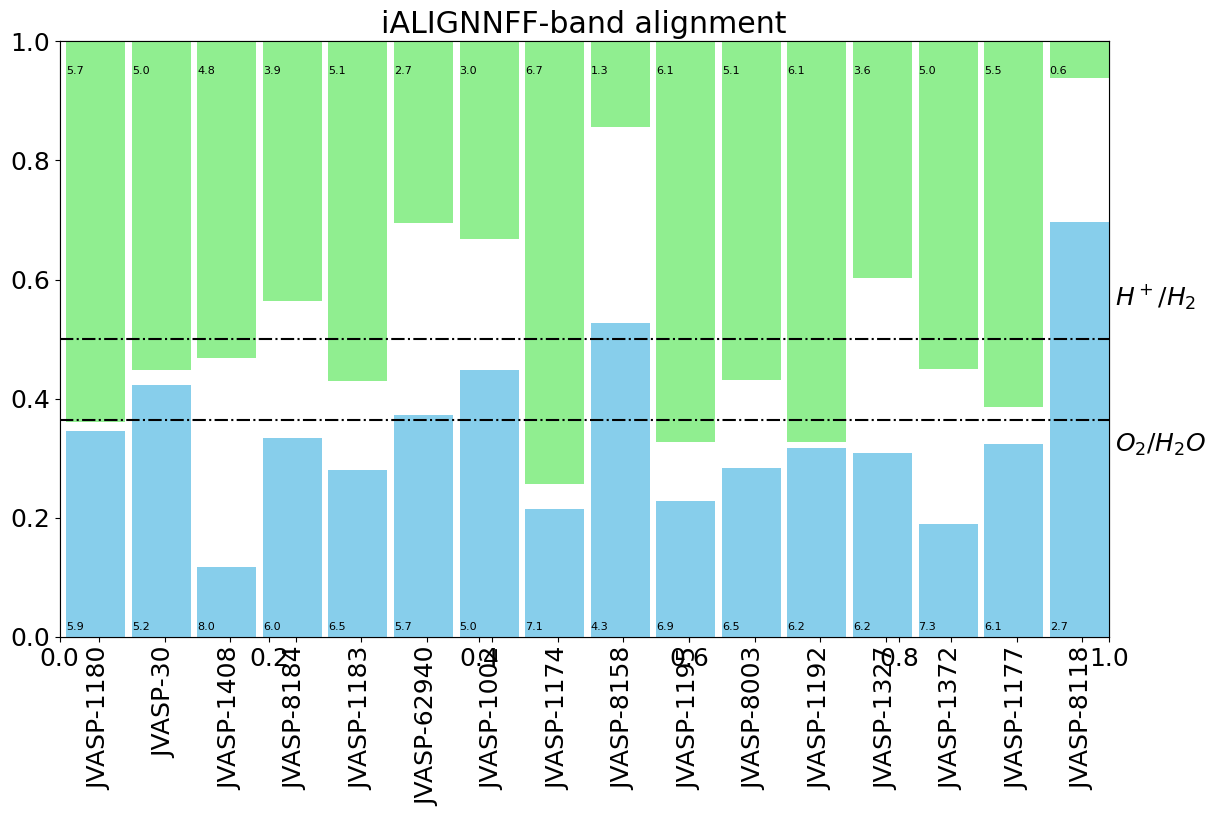

In [48]:
from math import floor

ppi = 100
figw = 1250
figh = 850
plt.close()
fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
ax = fig.add_subplot(1,1, 1)
plt.rcParams.update({"font.size": 18})
ax = fig.add_subplot()
x = np.arange(len(al_vbms)) + 0.5
emin_tmp = floor(min(al_vbms)) - 1.0
emin = emin_tmp
y = np.array(al_vbms) - emin
width = 0.9
ax.bar(x, y, bottom=emin, color="skyblue", width=width, align="edge")
ax.set_xticklabels([])
y = -np.array(al_cbms)
# ax.bar(x, y, bottom=cbms,color='lightgreen',width=width,align='edge')
ax.bar(x, y, bottom=al_cbms, color="lightgreen", width=width, align="edge")
ax.set_xlim(0.4, len(labels) + 0.4)
ax.set_ylim(emin_tmp, 0)


ax.set_title("iALIGNN-FF-band alignment")
ax.set_xticklabels([])

ax.set_xticks(np.arange(len(labels)) + 1, labels)
ax.set_xticklabels(labels, rotation=90)
ax.axhline(y=-4.5, linestyle="-.", color="black")
ax.axhline(y=-5.73, linestyle="-.", color="black")
ax.text(max(x) + 1, -4, "${H^+}/{H_2}$")
ax.text(max(x) + 1, -6.2, "${O_2}/{H_2O}$")
# plt.title("2Positions of VBM and CBM ")
# ax.set_ylabel('Energy wrt vacuum (eV)')
# ax.set_xlabel(r'$\leftarrow$2D materials$\rightarrow $')
# ax.set_ylabel(r'$\Delta \Theta / \omega $ \Huge{$\longleftarrow$}')
count = 0
for i, j in zip(al_cbms, al_vbms):
    count += 1
    plt.text(count - 0.5, emin_tmp + 0.1, round(-1 * j, 1), fontsize=8)
    plt.text(count - 0.5, -0.5, round(-1 * i, 1), fontsize=8)
ax.set_yticks([])



plt.tight_layout()
plt.show()